# Dynamics: simulation and control
This notebook focuses on the simulation of polyarticulated systems, with final exercices where simple control laws have to be designed. The first part deals with collision detection using the hppfcl module of pinocchio. We then build a complete simulation engine for rigid unilateral contacts. 

In [1]:
import gepetuto.magic

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide
    the solutions to some questions. Change it for %load if you want to see (and
    execute) the solution.


## Set up

We will use several models in this tutorial:
- a simple scene with 3 convex objects (buildSceneThreeBodies)
- a variation of this first scene with more objects and walls (buildScenePillsBox)
- a stack of cubes of various size (buildSceneCubes)
- a robot hand

In [2]:
from tp4.scenes import buildSceneThreeBodies, buildScenePillsBox, buildSceneCubes, buildSceneRobotHand

We rely on the HPP-FCL module of Pinocchio, which compute collision between geometries.

In [3]:
import hppfcl
import pinocchio as pin
import numpy as np
import time
from supaero2024.meshcat_viewer_wrapper import MeshcatVisualizer
from tp4 import compatibility
import matplotlib.pylab as plt

## A basic example of collisions

The goad of this section is to introduce a simple example of collision distances between bodies, and the underlying notions of witness points and segment and normal direction.

Let's build a simple scene with 3 objects and display their proximity.

In [4]:
# %load tp4/generated/example_display_witness_build
# Build a scene
model,geom_model = buildSceneThreeBodies()
data = model.createData()
geom_data = geom_model.createData()

# Start meshcat
viz = MeshcatVisualizer(model=model, collision_model=geom_model,
                        visual_model=geom_model)


*** You asked to start meshcat "classically" in tcp://127.0.0.1:6000
*** Did you start meshcat manually (meshcat-server)
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
q=pin.randomConfiguration(model)
viz.display(q)

In [6]:
viz.viewer.jupyter_cell()

We can compute the distances between the 3 objects. Let's do it and show the closest points.

In [7]:
from tp4.display_witness import DisplayCollisionWitnessesInMeshcat

In [8]:
# %load tp4/generated/example_display_witness_witness
# Build the viewer add-on to display the witnesses.
mcWitnesses = DisplayCollisionWitnessesInMeshcat(viz)


In [9]:
pin.computeDistances(model,data,geom_model,geom_data,q)
mcWitnesses.displayDistances(geom_data)

Each collision pair corresponds to a pair of closets points, respectively located at the surface of the collision geometries if they are not colliding. These points are sometime called the *witness* points.

The witness points are connected by the *witness* segment. This segment is normal to the two collision surfaces in the case the surface is smooth around the witness point. The normalized direction is called the collision *normal*. Its orientation is a convention (the most logical convention is to go from body 1 to body 2 of the collision pair).

Let's move the objects to better see these witness elements.

In [10]:
# %load tp4/generated/example_display_witness_trajectory
v = (np.random.rand(model.nv)*2-1)*1e-3
r0 = [ np.linalg.norm(q[7*i:7*i+3]) for i in range(model.nq//7) ]
for t in range(100):

    # Update the robot position along an arbitrary trajectory
    q = pin.integrate(model,q,v*10)
    for i in range(model.nq//7):
        q[7*i:7*i+3] *= r0[i]/np.linalg.norm(q[7*i:7*i+3])
    viz.display(q)

    # Display the witness points
    pin.computeDistances(model,data,geom_model,geom_data,q)
    mcWitnesses.displayDistances(geom_data)

    time.sleep(.01)


## Details about Pinocchio HPP-FCL 

Let's see now how to extract the contact and distance information from Pinocchio and the module HPP-FCL, and how to store this in a proper data structure.

### Geometry model
The geometry model contains a set of object, each described by a name, a geometry primitive and a placement with respect to a parent joint.

In [11]:
geom1 = geom_model.geometryObjects[0]
geom1.name, geom1.parentJoint, geom1.geometry, geom1.placement

('Convex_1',
 1,
   R =
 1 0 0
 0 1 0
 0 0 1
   p = -1.18174e-05    0.0312635    0.0693724)

In addition, we also store the pairs of geometry objects that should be considered when evaluating collisions and distances.

In [12]:
list(geom_model.collisionPairs)

[collision pair (0,1), collision pair (0,2), collision pair (1,2)]

### HPP-FCL computeDistances and computeCollisions
The geometry algorithms are implemented in HPP-FCL under two different sets of functions, which respectively compute the distance between bodies, and the collision between bodies.
When computing the distance, a unique pair of witness points is produced, and the signed distance is also evaluated.
When computing the collision, an effort is made to compute all the contact points, and early stop can be activated to reduce the algorithm cost as soon as a collision is found. 
All in all, for this initiation, both can be considered quite similarly.

Both functions are parametrized by a *request* object, and write their output in a *result* object. *Request* and *result* objects are preallocated in the geometry data, one of each for each pair of collisions. If you activate or deactivate a collision pair, you have to regenerate these objects (and so if you add a new geometry object in the list). 

In [13]:
len(geom_model.collisionPairs), len(geom_data.collisionRequests), len(geom_data.distanceResults)

(3, 3, 3)

The placement of the geometry objects with respect to world frame are stored in geom_data.oMg, and computed as
$$^oM_g(q) = ^oM_i(q) ^iM_g$$
with $^oM_g$ the placement of the object wrt world, $^oM_i$ the placement of the parent joint and $^iM_g$ the (fixed) placement of the object wrt the parent joint.

In [14]:
len(geom_model.geometryObjects),len(geom_data.oMg)

(3, 3)

This computation is triggered by *pin.updateGeometryPlacements*, after forward kinematics as been run or by forcing the refresh of the forward kinematics.

In [15]:
pin.updateGeometryPlacements(model,data,geom_model,geom_data,q)

The computation of the distances and collisions is triggered by their respective function and by default forces the kinematic update..

In [16]:
pin.computeCollisions(model,data,geom_model,geom_data,q)
pin.computeDistances(model,data,geom_model,geom_data,q)

These two functions actually iterate over each pair and run *pin.computeDistance* or *pin.computeCollision*, which in turn runs *hppfcl.distance* and *hppfcl.collide*. 
HPP-FCL only works with geometry placements, ignoring the kinematics and the configuration space which is provided by Pinocchio.
All these functions have very similar signatures, and Pinocchio is mostly doing a basing wrapping around the HPP-FCL library and gently connected the forward kinematics with the collision algorithms. 

### The *result* objects
The distance result contains the pair of witness points $p_1$ and $p_2$, the normal direction pointing from $p_1$ to $p_2$ and the signed distance.

In [17]:
d = geom_data.distanceResults[0]
print("p1:",d.getNearestPoint1())
print("p2:",d.getNearestPoint2())
print("n:",d.normal)
print("dist:",d.min_distance)
print("check:",np.cross(d.normal,d.getNearestPoint2()-d.getNearestPoint1())) # The two vectors are parallel.

p1: [ 0.13923644 -0.3030054  -0.14295444]
p2: [ 0.12472576 -0.13402196 -0.13027373]
n: [-0.08531745  0.99356029  0.07455791]
dist: 0.17007869445235735
check: [-1.56125113e-17 -1.30104261e-18  0.00000000e+00]


The collision object contains similar information, but can stores several witness pairs instead of a single one, or none if there is no collisions.
The collision is decided based on a security margin, tuned in the collision request object.

In [18]:
print('Margin:',geom_data.collisionRequests[0].security_margin)
c = geom_data.collisionResults[0]
print('Number of collisions:',len(c.getContacts()))

Margin: 0.0
Number of collisions: 0


Now choose a configuration in collision and look at the content of this contact list.

In [19]:
# %do_not_load_snippet tp4/generated/example_find_collisions_find
for trial in range(1000):
    q = pin.randomConfiguration(model)
    col = pin.computeCollisions(model,data,geom_model,geom_data,q)
    if col: break
assert(col)
viz.display(q)


In [20]:
# %load tp4/generated/example_find_collisions_print
for pairId,c in enumerate(geom_data.collisionResults):
    if len(c.getContacts())>0:
        contact = c.getContact(0)
        print([ n for n in dir(contact) if '__' not in n])
        break


['b1', 'b2', 'getNearestPoint1', 'getNearestPoint2', 'normal', 'o1', 'o2', 'penetration_depth', 'pos']


## From collision detection to contact model

### The maths
Once the collision are detected, we have to decide the model of the contact interaction that will happen at this location. It can range from a fixed 3D contact (bilateral), a sliding contact enforcing only constraints along the normal direction, a frictional contact or even a full 6D contact with no degree of freedom between the two corresponding bodies (and many other models you can imagine).
To describe the contact model, we best formulate it in a reference frame at the contact location. Here we arbitrarily decide to align the *z* direction of the contact frame with the normal direction (oriented from body 1 to body 2) and set the two other *x* and *y* directions to any arbitrary orthogonal basis of the tangential plane. If the collision distance is exactly 0 (which will never be), the center of the frame should be at the contact point. In practice, we can define either two contact frames at each witness point or a single one at the middle point between both. Since the contact distance will never be large, it should be approximately the same and both solutions are acceptable in practice.

In [21]:
OC1 = contact.getNearestPoint1()
OC2 = contact.getNearestPoint2()
normal = contact.normal

From these vectors, build the two contact frames $^oM_{c1}$ and $^oM_{c2}$ centered in $c_1$  and $c_2$ and with *z* axis aligned with the *normal* direction. You can for example use the pin.Quaternion.FromTwoVectors(v1,v2) function, which returns a rotation $r(.)$ such that $r(v_1)=v_2$ ie that transforms $v_1$ into $v_2$ (here we want to transform the *z* axis $z=[0,0,1]$ into the *normal* vector).

In [22]:
# %load tp4/generated/create_rigid_contact_models_for_hppfcl_frames
pair = geom_model.collisionPairs[pairId]
gid1,gid2 = pair.first,pair.second
g1 = geom_model.geometryObjects[gid1]
g2 = geom_model.geometryObjects[gid2]
jid1 = g1.parentJoint 
jid2 = g2.parentJoint 
oMj1 = data.oMi[jid1]
oMj2 = data.oMi[jid2]

# Compute translation and rotation of the contact placements
# If dist=0, both placements are identical (and should be somehow close
# when dist is reasonibly small).
quat = pin.Quaternion.FromTwoVectors(pin.ZAxis,normal) # orientation of the contact frame wrt world
assert(np.isclose(quat.norm(),1))
oMc1 = pin.SE3(quat.matrix(),OC1) # Placement of first contact frame in world
oMc2 = pin.SE3(quat.matrix(),OC2) # Placement of second contact frame in world


The pin.RigidConstaintModel class in Pinocchio conveniently stores these contact quantities: the two parent joints that carries the corresponding colliding bodies, the placements of the contact frames with respect to the joint frames $^{j1}M_{c1}$, $^{jc}M_{c2}$, and a flag specifying if the contact model is 3D (point contact) or 6D (surface contact), which will later be convenient to evaluate the corresponding Jacobian.

In [23]:
# %load tp4/generated/create_rigid_contact_models_for_hppfcl_model
contact_model = pin.RigidConstraintModel(
        pin.ContactType.CONTACT_3D,
        model,
        jid1,oMj1.inverse()*oMc1,
        jid2,oMj2.inverse()*oMc2,
        pin.LOCAL)


In [24]:
contact_data = contact_model.createData()

### Creation wrapper
This code has been conveniently wrapped in a dedicated function, that takes all the collision or distance results and returns a list of contact models.

In [25]:
from tp4.create_rigid_contact_models_for_hppfcl import createContactModelsFromCollisions,createContactModelsFromDistances

In [26]:
# %load tp4/generated/create_rigid_contact_models_for_hppfcl_example
pin.computeCollisions(model,data,geom_model,geom_data,q,False)
contact_models = createContactModelsFromCollisions(model,data,geom_model,geom_data)
contact_datas = [ cm.createData() for cm in contact_models ]

pin.computeDistances(model,data,geom_model,geom_data,q)
contact_models = createContactModelsFromDistances(model,data,geom_model,geom_data,
                                                       threshold=10) # threshold in meter
contact_datas = [ cm.createData() for cm in contact_models ]


### Display the contact models
A robot description (like the robot URDF) typically describes two sets of geometries: a first set, accurate, detailled and texture fore visualization and non real-time evaluations (called the *visual* model); a second one, less detailed, sometimes approximated or convexified, for efficient computations (often called the *collision* model).

Let's display in the 3D viewer the contact models with red contact patches (disks) located at the center of the contact frames and aligned with the *x-y* contact plane. 
To make it easy to render, we will put these patches in the *visual* model of the system. 
A fix set of patches is preallocated at initialization (and hidden or displaced far from the scene center when not useful). When contacts are created, the patches are revealed and properly place for rendering.
The functions in the file display_collision_patches have be written for that.

In [27]:
from tp4.display_collision_patches import preallocateVisualObjects,updateVisualObjects

In [28]:
# %load tp4/generated/example_display_collision_patches_create
# Obtained by simply copying the collision model
visual_model = geom_model.copy()
preallocateVisualObjects(visual_model)

# Start meshcat
viz = MeshcatVisualizer(model=model, collision_model=geom_model,
                        visual_model=visual_model)


*** You asked to start meshcat "classically" in tcp://127.0.0.1:6000
*** Did you start meshcat manually (meshcat-server)
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [29]:
viz.viewer.jupyter_cell()

In [30]:
# %load tp4/generated/example_display_collision_patches_display
updateVisualObjects(model,data,contact_models,contact_datas,visual_model,viz)
viz.display(q)


##  Building a (very) simple kinematic simulator

Let's build a very simple collision simulator. Starting from an initial configuration where some bodies are colliding, you have to choose a velocity of each body to disentangle the colliding parts.
The scene created above is composed of 3 bodies, each attached to a "free-flyer" joint. The configuration of the scene is the concatenation of the configuration of each joint, corresponding to translation and quaternion describing the placement of each body. The configuration velocity also is the concatenation of the velocity of each body, each corresponding to the spatial velocity $\nu = (v,\omega)$ of each body expressed in the local frame. 

In [31]:
# %load tp4/generated/example_separate_objects_hyperparams
# HYPER PARAMETERS OF THE PUSH STRATEGY
PUSH_FACTOR = .1
EPSILON = 1e-1
NB_ITER = 100
# Compute the contact information based on distances or collisions?
USE_DISTANCE = True


At each iteration, you have to choose a configuration velocity, then integrate it.

In [32]:
# Set minimal distance to be EPSILON
# (can be zero, but the rendering is less clear).
for r in geom_data.collisionRequests:
    r.security_margin = EPSILON

# Keep distance history for active pairs (indexed by contact name)
h_dist = {}

# Iteratively push the colliding pairs ...
for i in range(NB_ITER):

    # We will compute a change of configuration dq.
    # 0 if no active pair.
    dq = np.zeros(model.nv)

    # Compute the collision at current configuration.
    if USE_DISTANCE:
        pin.computeDistances(model,data,geom_model,geom_data,q)
    else:
        pin.computeCollisions(model,data,geom_model,geom_data,q)

    # From hppfcl contact information, build a pin.RigidContactModel
    if USE_DISTANCE:
        contact_models = createContactModelsFromDistances(model,data,geom_model,geom_data,EPSILON)
    else:
        contact_models = createContactModelsFromCollisions(model,data,geom_model,geom_data)
    contact_datas = [ cm.createData() for cm in contact_models ]

    # For each detected contact ...
    for cmodel,cdata in zip(contact_models,contact_datas):

        # Recover contact information
        jid1 = cmodel.joint1_id
        j1Mc1 = cmodel.joint1_placement
        jid2 = cmodel.joint2_id
        j2Mc2 = cmodel.joint2_placement

        # Compute signed distance
        oMc1 = cdata.oMc1 = data.oMi[jid1]*j1Mc1
        oMc2 = cdata.oMc2 = data.oMi[jid2]*j2Mc2
        dist = oMc1.actInv(oMc2.translation)[2]-EPSILON  # signed distance
        
        # ### TODO
        # Here, do something to the velocity of the two joints carrying the 
        # two colliding bodies.
        # Displacement for body 1
        dq[model.idx_vs[jid1]:model.idx_vs[jid1]+6] += 0 ### TODO FIX ME
        # Displacement for body 2
        dq[model.idx_vs[jid2]:model.idx_vs[jid2]+6] -= 0 ### TODO FIX ME
        
        # Log the distance in h_dist for future plot
        if cmodel.name not in h_dist:
            h_dist[cmodel.name] = np.zeros(NB_ITER)
        h_dist[cmodel.name][i] = dist

    # Finally, modify the current config q with the push dq
    q = pin.integrate(model,q,dq)

    # Display the current configuration
    if i % 10 == 0:
        # Meshcat is slow to display the patches, display once in a while
        updateVisualObjects(model,data,contact_models,contact_datas,visual_model,viz)
        viz.display(q)


If you don't have any strong ideas, you can start to compute a "push" repulsive 3D velocity that the first witness point should adopt. The second witness point should likely adopt the opposite velocity. This is the value of the velocity vector field at the contact point. Now choose the spatial velocity at the center of the body so that the value of the corresponding vector field matches. In a first trial, a spatial velocity with 0 angular velocity $\omega$ should be evident to guess. Can you imagine a more efficient linear+angular velocity that would work as well?

In [33]:
%do_not_load_snippet tp4/generated/example_separate_objects_loop

### With a more complex scene
Now let's load a square jar full of pills. Run the same algorithm on it. 

In [34]:
# %load tp4/generated/scenes_pills
model,geom_model = buildScenePillsBox(seed=2,nobj=30,wall_size=2.0,one_of_each=True)
visual_model = geom_model.copy()
viz = MeshcatVisualizer(model=model, collision_model=geom_model,
                        visual_model=geom_model)

# Generate colliding configuration
data = model.createData()
geom_data = geom_model.createData()
for i in range(10):
    q0 = pin.randomConfiguration(model)
    pin.computeCollisions(model,data,geom_model,geom_data,q0)
    if sum([ len(c.getContacts()) for c in geom_data.collisionResults ])>10:
        break
    print(sum([ len(c.getContacts()) for c in geom_data.collisionResults ]))


*** You asked to start meshcat "classically" in tcp://127.0.0.1:6000
*** Did you start meshcat manually (meshcat-server)
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [35]:
q = q0.copy()
viz.display(q)
viz.viewer.jupyter_cell()

You can plot the convergence of the colliding bodies from initial negative (penetration) distance to 0.

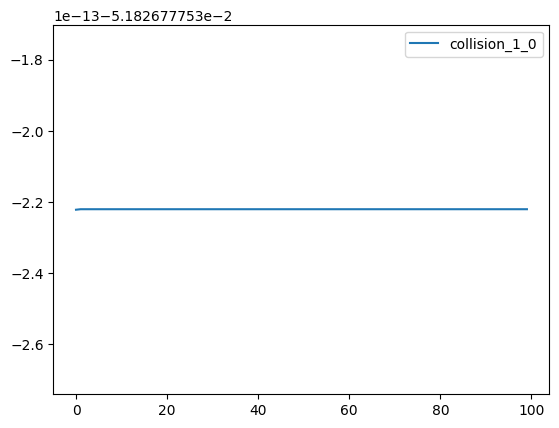

In [36]:
# %load tp4/generated/example_separate_objects_plot
# Plot the distances
for k,v in h_dist.items():
    h = plt.plot(v,label=k)
plt.legend()


## Contact-less simulator

We now have all the contact information, let's look at the system dynamics. 
We will write a contact-less simulator, just integrating free fall.
Better use an actuated model for that.

In [53]:
### Model of a robot hand

In [40]:
model,geom_model = buildSceneRobotHand()
q0 = model.referenceConfigurations['default']
data = model.createData()

In [41]:
visual_model = geom_model.copy()
viz = MeshcatVisualizer(model=model, collision_model=geom_model,
                        visual_model=geom_model)
viz.display(q0)
viz.viewer.jupyter_cell()

*** You asked to start meshcat "classically" in tcp://127.0.0.1:6000
*** Did you start meshcat manually (meshcat-server)
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


### Evaluating the core elements of the dynamics

In a first time, let's play with the dynamics without constraints.
Choosing an arbitrary joint torque $\tau_q$, inocchio can compute the robot acceleration and integrate it.
The dynamic equation of the robot is $M a_q + b = \tau_q$, with $M$ the mass, $a_q$ the joint acceleration and $b$ the drift.
The mass matrix can be computed using *CRB* algorithm (function of q). The drift is computed using *NLE* (nonlinear effects) algorithm (function of $q$, $v_q$). 


In [45]:
# %load tp4/generated/example_control_init
q = q0.copy()
vq = np.zeros(model.nv)


In [47]:
# %load tp4/generated/example_control_mass
M = pin.crba(model, data, q)
b = pin.nle(model, data, q, vq)


These terms correspond to the inverse dynamics. They can be numerically inverted to compute the direct dynamics.

Using $M$ and $b$ computed by the above algorithms, and knowing a given set of joint torques $\tau_q$, how would you compute $a_q$ so that $M a_q + b = \tau_q$?

In [52]:
%do_not_load_snippet tp4/generated/example_control_dyninv

The inverse-dynamics algorithm indeed compute the needed torques to achieve a given acceleration. We can use the *RNEA* function to double-check our result:

In [51]:
print(pin.rnea(model,data,q,vq,aq)-tauq)
print(pin.rnea(model,data,q,vq,vq*0)-pin.nle(model,data,q,vq))

NameError: name 'aq' is not defined

### Integrating the acceleration

Once aq as been computed, it is straight forward to integrate it to velocity using $v_q += a_q \Delta t$. 
Integration to joint position is more complex in general, as we saw for the mobile robot. Here, $n_q = n_v$ and everything is Euclinea, so a simple += integration would work, but since it is implemented in pinocchio, let's keep the good habits:

In [ ]:
DT = 5e-3

In [54]:
# %load tp4/generated/example_control_integrate
vq += aq * DT
q = pin.integrate(model, q, vq * DT)


Now, you should be able to implement a first simulation (not a rendering any more) of the robot behavior when no torque is applied (tauq = 0).



In [ ]:
tauq = np.zeros(robot.model.nv)

Fill the template below to get a free-falling dynamics.

In [ ]:
for it in range(1000):
    t = it*dt
    ### Compute acceleration instead of this comment
    ### Integrate the acceleration twice instead of this comment
    
    if i%20==0: 
        robot.display(q)
        time.sleep(20*dt)

Now modify the simulator to encompass joint friction, i.e. the torque is opposite to the velocity with a friction coefficient $K_f$ (take $K_f=0.1$ as a start).

## (optional) Reference trajectory
If you like it, a class is implemented to compute a reference trajectory as a sinus with various frequency, phase and amplitude on each joint. It is implemented in traj_ref with the class TrajRef.

In [ ]:
from tp4.traj_ref import TrajRef

In this simple example, we define a trajectory in dimension 3, starting at t=0 from q=[0,0,0], with 3 sinusoid of frequency 1,2 and 3, all with the same amplitude 1.5.

In [ ]:
# %load  tp4/generated/traj_ref_main
qdes = TrajRef(np.array([0,0,0.]),omega = np.array([1,2,3.]),amplitude=1.5)
t = 0.2
print(qdes(t),qdes.velocity(t),qdes.acceleration(t))

## Proportional-derivative and computed torque

Now choose a reference joint position (possibly time varying, like in the hand example).
The joint torques can then be computed to track the desired position, with $\tau_q = -K_p (q-q^{des}) - K_v v_q$. Both gains $K_p$ and $K_v$ should be properly chosen. Optimal tracking is obtained with $K_v = 2 \sqrt{K_p}$. 
In general, a desired velocity is also tracked to avoid tracking errors.



First choose the PD gains:

In [ ]:
# %load tp4/generated/example_control_hyper
# Hyperparameters for the control and the simu
Kp = 50.               # proportional gain (P of PD)
Kv = 2 * np.sqrt(Kp)   # derivative gain (D of PD)
dt = 1e-3              # simulation timestep


Then choose the reference trajectory.

In [ ]:
# %load tp4/generated/example_control_trajref
from tp4.traj_ref import TrajRef
qdes = TrajRef(robot.q0,omega = np.array([0,.1,1,1.5,2.5,-1,-1.5,-2.5,.1,.2,.3,.4,.5,.6]),amplitude=1.5)


Finally, implement the control loop using the following template.

In [ ]:
# %load tp4/generated/example_control_loop
hq    = []   ### For storing the logs of measured trajectory q
hqdes = []   ### For storing the logs of desired trajectory qdes
for i in range(10000):
    t = i*dt

    # Compute the PD control.
    tauq = np.zeros(robot.model.nv)   # REPLACE ME
    
    # Compute the model M and b.
    M = np.eye(robot.model.nv)        # REPLACE ME
    b = np.zeros(robot.model.nv)      # REPLACE ME
    
    # Simulated the resulting acceleration (forward dynamics
    aq = np.zeros(robot.model.nv)     # REPLACE ME

    # Integrate the acceleration.
    vq += np.zeros(robot.model.nv)    # REPLACE ME
    q  = q+np.zeros(robot.model.nv)   # REPLACE ME

    # Display every TDISP iterations.
    TDISP = 50e-3    # Display every 50ms
    if not i % int(TDISP/dt):  # Only display once in a while ...
        viz.display(q)
        time.sleep(TDISP)

    # Log the history.
    hq.append(q.copy())
    hqdes.append(qdes.copy())



Here is the solution, should you need it.

In [ ]:
%do_not_load_snippet tp4/generated/example_control_loop

Here, there is a strong coupling between joints, due to the mass matrix that is not compensated in the simple PD law. In theory, the computed torques is to compute the joint torque by inverse dynamics from a reference joint acceleration. This boils down to canceling the simulation equation by choosing the proper terms in the control law. It is now very interesting to implement in case of perfect dynamics knowledge. It might be more interesting to study in case the simulation is done with the perfect M, while the control is computed with approximate M (for example, using only the diagonal terms of the mass matrix). Let's rather simulate contact.


It is intersting to plot the results. In the solution of the previous example, the effective and desired position q and qdes have been stored in a log list. We can display them with matplotlib.

In [ ]:
plt.subplot(211)
plt.plot([q[2] for q in hq])
plt.plot([q[2] for q in hqdes])
plt.ylabel('Joint #2')
plt.subplot(212)
plt.plot([q[3] for q in hq])
plt.plot([q[3] for q in hqdes]);
plt.ylabel('Joint #1')
plt.xlabel('Iterations')